In [1]:
#: the usual imports
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

# Lecture 13

### The Bootstrap and Confidence Intervals

## Question

- What is the median salary of San Diego city employees?
- All city employee salary data is public.

In [2]:
#: read in the data
population = Table.read_table('salaries.csv')
population

Employee Name,Job Title,Base Pay,Overtime Pay,Other Pay,Benefits,Total Pay,Total Pay & Benefits,Year,Notes,Agency,Status
David P Gerboth,Fire Battalion Chief,81917,172590,68870,5194,323377,328571,2017,nan,San Diego,FT
Glen A Bartolome,Fire Captain,85904,120682,99408,10107,305994,316101,2017,nan,San Diego,FT
Scott C Chadwick,Chief Operating Officer,255000,0,31164,22688,286164,308852,2017,nan,San Diego,FT
David W Pilkerton,Fire Battalion Chief,100110,118798,62895,18746,281803,300549,2017,nan,San Diego,FT
Daniel S Reeves,Fire Captain,41389,196284,42027,20125,279700,299825,2017,nan,San Diego,PT
Edward S Jones,Fire Captain,46020,171896,59944,19669,277860,297529,2017,nan,San Diego,PT
Richard L Ballard,Fire Battalion Chief,99629,93528,61055,16630,254212,270842,2017,nan,San Diego,FT
Mark A Hovey,Retirement Administrator,240000,0,6190,21909,246190,268099,2017,nan,San Diego,FT
Adrian A Blackson,Fire Captain,44280,196978,16933,8304,258191,266495,2017,nan,San Diego,PT
Stacey D Lomedico,Asst Chief Oper Ofcr,215000,0,20352,30087,235352,265439,2017,nan,San Diego,FT


## The median salary

- We can use `np.median()`:

In [3]:
#...population_median
# the median of the "Total Pay" column
population_median = np.median(population.column('Total Pay'))
population_median

66665.5

## But now...

- ...suppose we don't have access to this data.
- It is costly and time-consuming to survey *all* 11,000+ employees.
- So we gather salaries for a random sample of, say, 500 people.
- Hope the median of the sample $\approx$ median of the population.

## In the language of statistics...

- The full table of salaries is the **population**.
- The median salary of all employees is a **parameter** of this population.
- We observe a **sample** of 500 salaries from the population.
- We really want the population median, but we don't have the whole population.
- So we compute sample median, a **statistic** as an **estimate** of the population median.
- Hopefully the sample median is close to the population median.

## The sample median

- Let's survey 500 employees at random.
- We can use `.sample()`:

In [6]:
#: take a sample of size 500
sample_500 = population.sample(500, with_replacement=False)

In [7]:
#: compute the sample median
sample_median = np.median(sample_500.column('Total Pay'))
sample_median

69879.5

## How confident are we?

- Our estimate depended on a random sample.
- If our sample was different, our estimate would've been different, too.
- **How different could the estimate have been?**
- Our confidence in the estimate depends on the answer.

## The sample median is random

- The sample median is a random number.
- It comes from some distribution of how the sample median could have turned out, based on which 500 people were in our sample.
    - This is called the sampling distribution.
    - It's not known to us, because we only have one sample.
- How different could the estimate have been?
    - "Narrow" sampling distribution $\Rightarrow$ not too different
    - "Wide" sampling distribution $\Rightarrow$ quite different
- **What is the distribution of the sample median?**

## A (costly) approach

- Every sample of 500 people gives me one observation of the sample median.
- So draw a bunch of samples, compute medians.

In [8]:
#: imports for animation
from lecture import sampling_animation
from IPython.display import HTML

In [9]:
%%capture
anim, sample_medians = sampling_animation(population)

In [10]:
#: display animation
HTML(anim.to_jshtml())

## Visualize the distribution

- We can plot the distribution of the sample median with a histogram.
- This is an approximation using 128 samples.
- Sample median is usually in the range [62,000, 70,000].

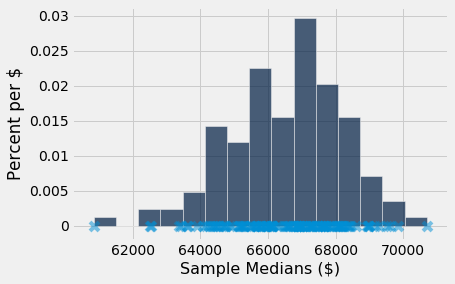

In [11]:
#: plot a histogram
Table().with_column('Sample Medians', sample_medians).hist(bins=15, unit='$')

# show each sample median as an 'x'
plt.scatter(sample_medians, np.zeros_like(sample_medians), marker='x', s=80, alpha=.5).set_zorder(2)

## The problem

- Drawing new samples like this is costly (why not just do a census?)
- Often, we can't ask for new samples from the population.
- The bootstrap:
    - the sample itself looks like the distribution.
    - so re-sampling from the sample is like drawing from the distribution.

In [12]:
#: a trick to plot the sample and the distribution side-by-side
bins=np.arange(10_000, 300_000, 10_000)
labels = ['Population']*population.num_rows + ['Sample']*sample_500.num_rows
together = population.append(sample_500).with_column('Label', labels)
# together.show()

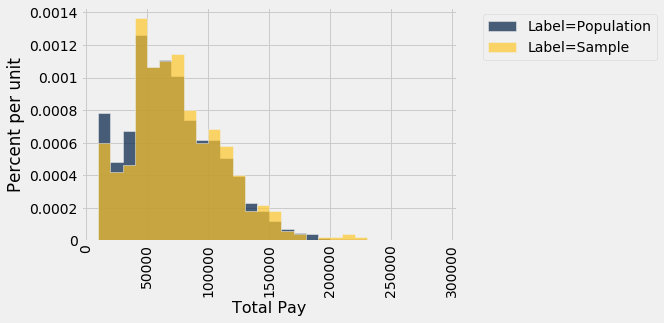

In [13]:
#: plot
together.hist('Total Pay', group='Label', bins=bins)

## The bootstrap

- We have a sample of 500 salaries, we want another.
- Can't draw from the population.
- But the original sample looks like the population.
- So we re-sample the sample.

## Discussion question

Which of these effectively resamples the sample, simulating the drawing of a new sample of 500 people?

- A) `np.random.choice(sample_500, 500, replace=True)`
- B) `np.random.choice(sample_500, 500, replace=False)`
- C) `sample_500.sample(with_replacement=True)`
- D) `sample_500.sample(with_replacement=False)`

## Answer

- If we sample without replacement, we're just shuffling.
- So we sample *with* replacement to get something new. (C)

## Running the bootstrap

- Now we can simulate new samples by bootstrapping
- I.e., we sample with replacement from our original sample

In [14]:
n_resamples = 5000

boot_medians = make_array()
for i in range(n_resamples):
    # perform bootstrap resampling
    resample = sample_500.sample(500, with_replacement=True)
    
    # compute the median
    median = np.median(resample.column('Total Pay'))
    
    # tack it on to our list of medians
    boot_medians = np.append(boot_medians, median)

## Bootstrap distribution of the sample median

- Most of the time, the sample median is in the range [60,000, 70,000].
- Similar to what we found before.
- The population median (red dot) is near the middle.

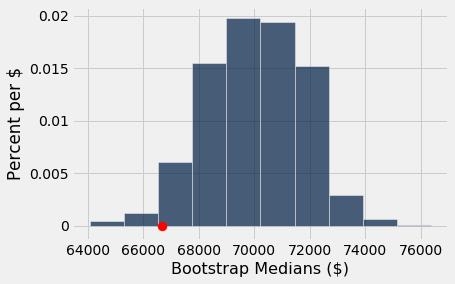

In [15]:
#: visualize
Table().with_column('Bootstrap Medians', boot_medians).hist(unit='$')
plt.scatter(population_median, 0, color='red', s=80).set_zorder(2)

## Bootstrap rules of thumb

- The bootstrap is an awesome tool:
    - We used just one sample to get the (approximate) distribution of the sample median.
- But it has limitations:
    - Requires sample to be good approximation of population.
             - A large random sample will look like the population, by the Law of Averages/Large Numbers.
    - Not good for sensitive parameters, like maximum.
             - Don't want the parameter to be influenced by rare values in the population.
    - Works best when probability distribution of the statistic is roughly bell-shaped.
    - Can be slow (recommend 10,000+ bootstrap samples)

## Example: bootstrapping in the German tank problem, version 1

- Suppose the population consists of 400 tanks $\leftarrow$ **parameter**
- We observe a random sample of 30 tanks
- Our estimator will be the *twice the sample mean* $\leftarrow$ **statistic**

In [19]:
#: 400 tanks
tank_population = Table().with_column('Serial Number', np.arange(400)+1)
tank_population

Serial Number
1
2
3
4
5
6
7
8
9
10


In [18]:
#: sample 30 tanks
np.random.seed(48)
tank_sample = tank_population.sample(30, with_replacement=False)
tank_sample

Serial Number
151
207
192
244
386
173
95
281
353
199


In [20]:
2*tank_sample.column('Serial Number').mean()

415.1333333333333

## Running the bootstrap

In [21]:
n_resamples = 5000

boot_doubled_means = make_array()
for i in range(n_resamples):
    # resample
    resample = tank_sample.sample(with_replacement=True)
    
    # compute doubled mean
    boot_doubled_mean = 2*resample.column('Serial Number').mean()
    
    boot_doubled_means = np.append(boot_doubled_means, boot_doubled_mean)

## Visualize

- The bootstrap distribution surrounds the true parameter, 400.

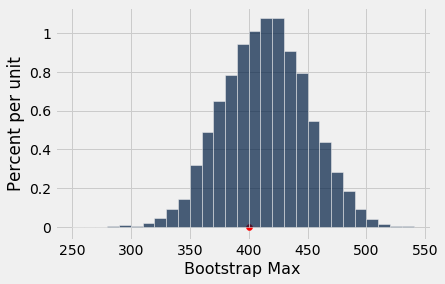

In [22]:
Table().with_column('Bootstrap Max', boot_doubled_means).hist(bins=np.arange(250, 550, 10))
plt.scatter(400, 0, color='red')

## Example: bootstrapping in the German tank problem, version 2

- Suppose the population consists of 400 tanks $\leftarrow$ **parameter**
- We observe a random sample of 30 tanks
- Our estimator will be the *maximum in the sample* $\leftarrow$ **statistic**

In [ ]:
#: 400 tanks
tank_population = Table().with_column('Serial Number', np.arange(400)+1)

In [25]:
#: sample 30 tanks
np.random.seed(48)
tank_sample = tank_population.sample(30, with_replacement=False)
tank_sample

Serial Number
151
207
192
244
386
173
95
281
353
199


In [24]:
tank_sample.column('Serial Number').max()

386

## Running the bootstrap

In [26]:
n_resamples = 5000

boot_maxes = make_array()
for i in range(n_resamples):
    # resample
    resample = tank_sample.sample(with_replacement=True)
    
    # compute max
    boot_max = resample.column('Serial Number').max()
    
    boot_maxes = np.append(boot_maxes, boot_max)

## Visualize

- The bootstrap distribution doesn't surround the true parameter, 400. Why?

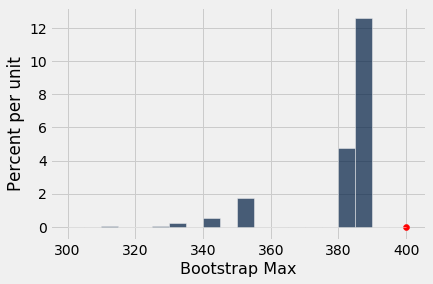

In [27]:
Table().with_column('Bootstrap Max', boot_maxes).hist(bins=np.arange(300, 405, 5))
plt.scatter(400, 0, color='red')

# Confidence Intervals

## Confidence intervals

- Bootstrapping approximates the distribution of an estimate
- The true parameter typically lies in the bulk of the distribution
- We can give an interval that we are confident that the correct value lies within

## A 95% confidence interval for median salary

- Recall our bootstrap distribution of the sample median
- Suppose by "bulk", we mean containing the middle 95% of the area.

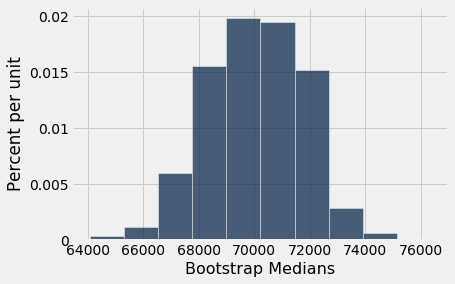

In [28]:
#: visualize
Table().with_column('Bootstrap Medians', boot_medians).hist()

## Finding the endpoints

- We want to find two points, $x$ and $y$, such that the area:
    - to the left of $x$ is about 2.5%
    - to the right of $y$ is about 2.5%
- Then the interval $[x,y]$ will have about 95% of the total area
- I.e., we want the 2.5th percentile and 97.5th percentile.

## Computing percentiles

- Use `percentile()` function:
    - First argument: percentile to find, a number in [0, 100]
    - Second argument: array of values

In [29]:
left = percentile(2.5, boot_medians)
left

66590.0

In [30]:
right = percentile(97.5, boot_medians)
right

73243.0

In [31]:
#: our interval is
[left, right]

[66590.0, 73243.0]

## Visualizing our 95% confidence interval

- Let's draw the interval on the histogram.
- 95% of the bootstrap medians fell into this interval.

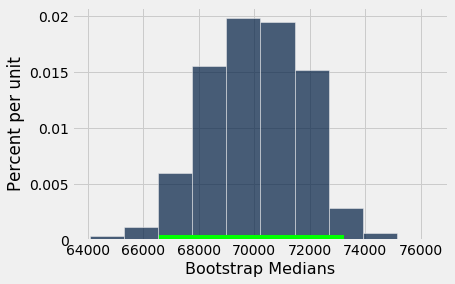

In [32]:
#: visualize
Table().with_column('Bootstrap Medians', boot_medians).hist()
plt.plot([left, right], [0, 0], color='lime', linewidth=10)

## Discussion question

Would an 80% confidence interval be bigger, smaller, or the same size?

- A) Bigger
- B) Smaller
- C) The same size

## Discussion Question

Suppose you had the true distribution of the sample median and used it to compute a 100% confidence interval. And suppose you compute a 100% confidence interval using the bootstrap. Which is bigger?

- A) The first confidence interval (from the true distribution).
- B) The second confidence interval (from the boostrap).
- C) They're the same size.

## Interpreting confidence intervals

- 95% of our bootstrap medians fell within this interval
- We're pretty confident that the true median does, too.
- How confident should we be about this?

## Capturing the correct value

- If we run the bootstrap again, we get a different distribution.
- And so we get a different 95% confidence interval.
- 95% of the time, the interval will capture the correct median.

## Interpreting confidence intervals

- Doesn't have to be for the same experiment!
- Suppose you only ever make 95% confidence intervals.
- Then roughly 95% of the CIs you make in your life will contain the true value of the thing being estimated.

## Misinterpreting confidence intervals

- A 95% confidence interval has a 95% chance of containing the true value of the thing being estimated.
- The interval is random, not the thing being estimated!

## Misinterpreting confidence intervals

- Our 95% confidence interval for the median salary was:

In [33]:
#: remember...
[left, right]

[66590.0, 73243.0]

- This does not mean that 95% of salaries are in this range!

## The Big Simulation

Testing the assumptions of our confidence percentile

In [34]:
def bootstrap_median(sample_from_population, label, repetitions):
    resampled_medians = []
    for i in np.arange(repetitions):
        resample = sample_from_population.sample()
        median = np.median(resample.column(label))
        resampled_medians.append(median)
    return resampled_medians

left_ends = make_array()
right_ends = make_array()

all_salaries = population.select('Total Pay')
for i in np.arange(100):
    sample_from_pop = all_salaries.sample(200, with_replacement=False)
    medians = bootstrap_median(sample_from_pop, 'Total Pay', 5000)
    left_ends = np.append(left_ends, percentile(2.5, medians))
    right_ends = np.append(right_ends, percentile(97.5, medians))
    print('Iteration:', i)

intervals = Table().with_columns(
    'Left', left_ends,
    'Right', right_ends
)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [35]:
intervals.show(3)

Left,Right
65041,75435
64757,80189.5
62915.5,75515.5


In [36]:
(intervals
 .where('Left', are.below(population_median))
 .where('Right', are.above(population_median))
 .num_rows)
#How many intervals contained the median? 

93

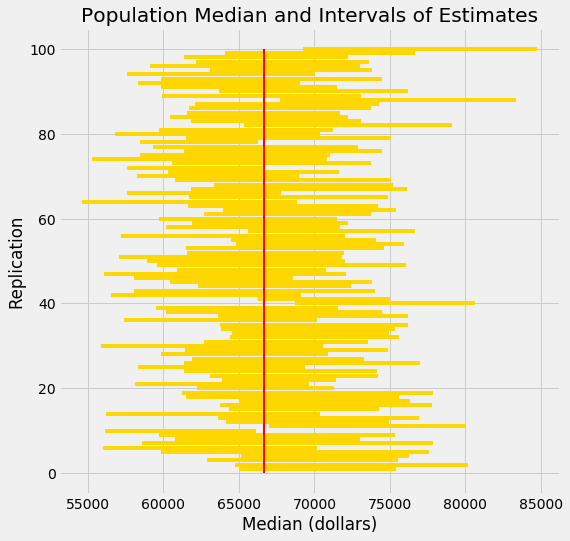

In [37]:
replication_number = np.ndarray.astype(np.arange(1, 101), str)

intervals2 = Table(replication_number).with_rows(make_array(left_ends, right_ends))

plt.figure(figsize=(8,8))
n=100
for i in np.arange(n):
    ends = intervals2.column(i)
    plt.plot(ends, make_array(i+1, i+1), color='gold')
plt.plot(make_array(population_median, population_median), make_array(0, n), color='red', lw=2)
plt.xlabel('Median (dollars)')
plt.ylabel('Replication')
plt.title('Population Median and Intervals of Estimates');

## Average Age of Moms

In [38]:
births = Table.read_table('baby.csv')
births

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


In [39]:
ages = births.select('Maternal Age')
ages

Maternal Age
27
33
28
23
25
33
23
25
30
27


## Bootstrapping the Mean

In [40]:
sample_size = ages.num_rows
n_resamples = 5000

boot_means = make_array()
for i in np.arange(n_resamples):
    # perform bootstrap resampling
    resample = ages.sample(sample_size, with_replacement=True)
    
    # compute the mean
    mean = np.mean(resample.column('Maternal Age'))
    
    # append to our array of means
    boot_means = np.append(boot_means, mean)

In [41]:
left = percentile(2.5, boot_means)
right = percentile(97.5, boot_means)
np.round(left, 1), np.round(right, 1)

(26.9, 27.6)

## Visualization

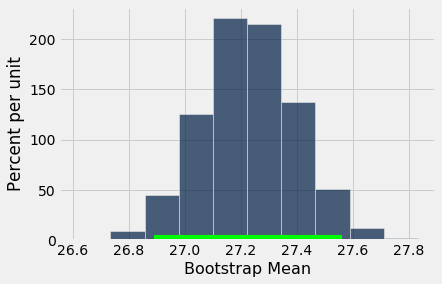

In [42]:
Table().with_column('Bootstrap Mean', boot_means).hist()
plt.plot([left, right], [0, 0], color='lime', linewidth=10)

## Discussion Question

Our confidence interval is (26.9, 27.6)

**True or False?**  
About 95 percent of the mothers in the population were between 26.9 and 27.6 years old.

A. True  
B. False

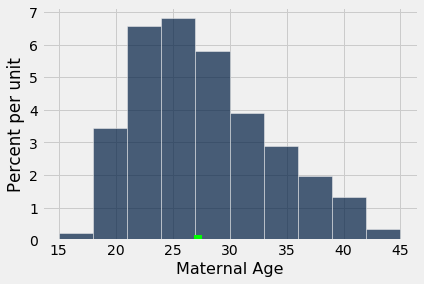

In [44]:
baby = Table.read_table('baby.csv')
baby.select('Maternal Age').hist()
plt.plot([left, right], [0, 0], color='lime', linewidth=10)